In [1]:
# Simulated BB clustering notebook using simple Acid set from Enamine.
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
#from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import kmedoids

import seaborn as sns
import umap

from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_fingerprint(mol,radius,bits):
    try:
        fp=AllChem.GetMorganFingerprintAsBitVect(mol,radius,bits)
        return(fp)
    except:
        print(f'{mol} failed in RDkit')
        return (np.nan)

In [3]:
df = PandasTools.LoadSDF(filename = "Data/Enamine_Acids.sdf")
print(len(df))
# add a few descriptors:
df['rot_b'] = df['ROMol'].apply(lambda x: Chem.rdMolDescriptors.CalcNumRotatableBonds(x))
df['HAC'] = df['ROMol'].apply(lambda x:  Chem.rdMolDescriptors.CalcNumHeavyAtoms(x))
df['MW'] = df['ROMol'].apply(lambda x:  Chem.rdMolDescriptors.CalcExactMolWt(x))
df['acid_count'] = df['ROMol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmarts('[CX3](=O)[OX1H0-,OX2H1]'))))



995


In [4]:
# filter out high # of rotatable bonds
# remove compounds with two acids
# remove ones with a primary or secondary amine
cur_size = len(df)
amine = Chem.MolFromSmarts('[NX3;H2,H1;!$(N-C=[O,N,S])]')
#
df = df[~(df['ROMol'] >= amine)]
print(f"removed {cur_size - len(df)} amines")
cur_size = len(df)
# remove multiple acids:
df = df[df['acid_count']==1]
print(f"removed {cur_size - len(df)} multiple acids")
cur_size = len(df)
# remove lots of rotatable bonds
df = df[df['rot_b']<6]
print(f"removed {cur_size - len(df)} with > 6 rot_bonds")
cur_size = len(df)
print(len(df))
df.reset_index(inplace=True,drop=True)

removed 148 amines
removed 89 multiple acids
removed 59 with > 6 rot_bonds
699


In [5]:
# generate FPs
n=3
bits = 1024
df['fp'] = df['ROMol'].apply(lambda x: generate_fingerprint(x,n,bits))

In [6]:
# Calculate the Tanimoto distance matrix
distance_matrix = []
fp_list = df['fp'].to_list()
for i in range(len(fp_list)):
    row = []
    for j in range(len(fp_list)):
        # Calculate Tanimoto similarity
        similarity = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
        
        # Convert to Tanimoto distance
        distance = 1 - similarity
        row.append(distance)
    distance_matrix.append(row)

distance_matrix = np.array(distance_matrix)
X = np.stack(df.fp)

In [7]:
results = []
for i in range(5,500,5):
    km = kmedoids.pam(distance_matrix,i,random_state=42)
    labels = km.labels
    s_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    km_sil = kmedoids.silhouette(distance_matrix, labels)[0]
    results.append({'k_value':i, 'sil_score':s_score,'km_sil': km_sil, 'db_score': db_score})

<Axes: xlabel='k_value', ylabel='sil_score'>

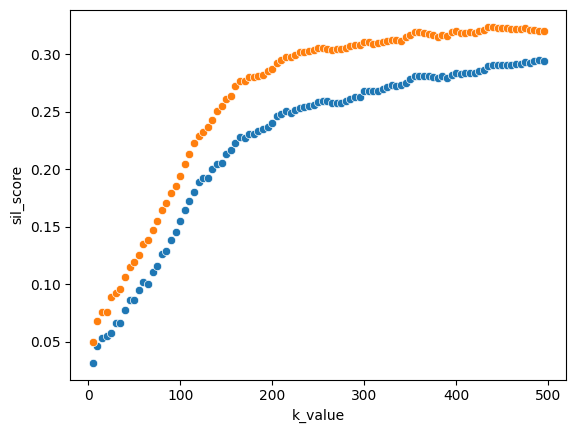

In [8]:
result_df = pd.DataFrame(results)
sns.scatterplot(data=result_df, x='k_value', y='sil_score')
sns.scatterplot(data=result_df, x='k_value', y ='km_sil')

<Axes: xlabel='k_value', ylabel='db_score'>

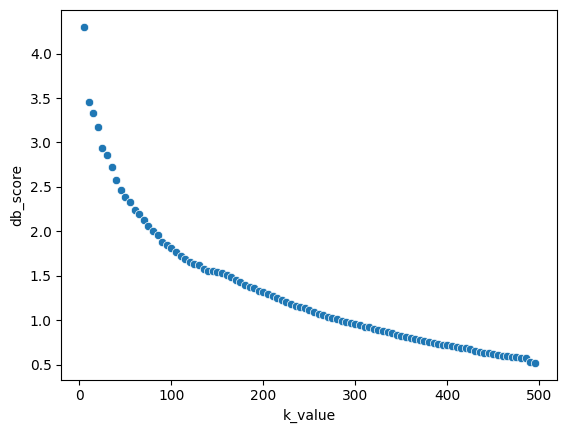

In [9]:
result_df = pd.DataFrame(results)
sns.scatterplot(data=result_df, x='k_value', y='db_score')

In [10]:
# Pick a reasonable number of clusters based on the scores & how many building blocks we would like
n= 160

In [11]:
km = kmedoids.pam(distance_matrix,n)

In [12]:
df['cluster'] = km.labels
df['mediod'] = [1 if i in km.medoids else 0 for i in range(len(df)) ]

/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

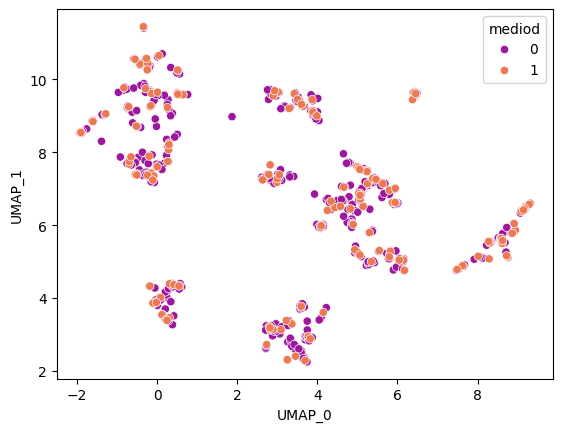

In [13]:
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = True,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(df['fp'].to_list())
df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='mediod', palette='plasma')

<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

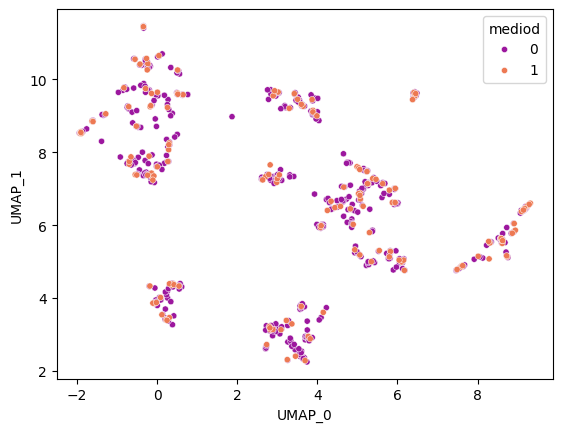

In [14]:
sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='mediod', palette='plasma',s=20)

In [15]:
group_sizes = df.groupby('cluster').size()
top_medoid_clusters = group_sizes.sort_values(ascending=False)[0:50].index.to_list()

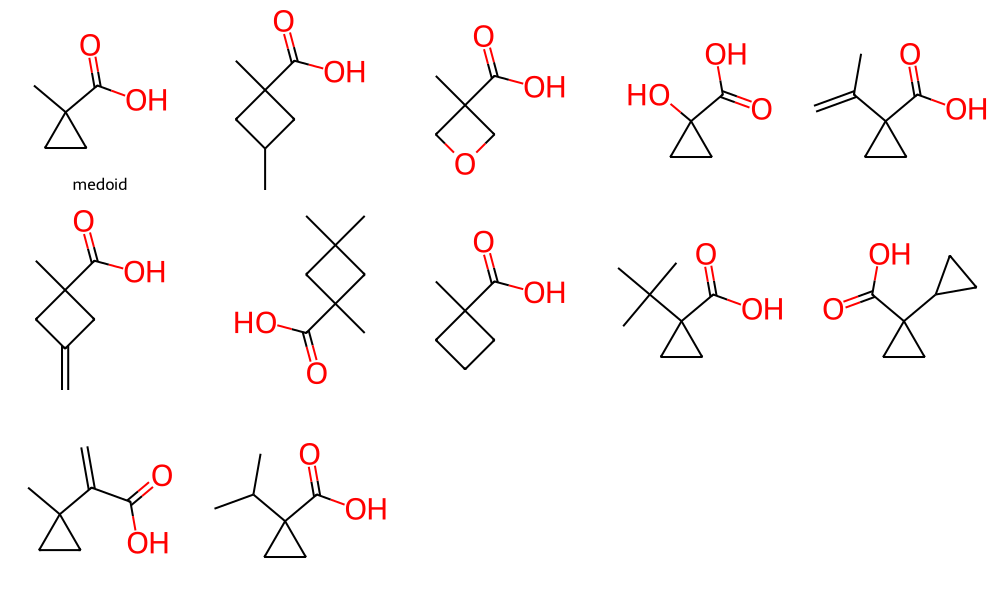

In [16]:
cluster= 6
Chem.Draw.MolsToGridImage(mols=df[df['cluster']==cluster]['ROMol'].to_list(),
                         legends=["medoid" if i==1 else "" for i in df[df['cluster']==cluster]['mediod']],
                         molsPerRow=5, subImgSize=(200, 200))

In [17]:
from rdkit.ML.Cluster import Butina
nfps = len(distance_matrix)
cutoff = 0.4
butina_cl = Butina.ClusterData(distance_matrix,nfps,cutoff,isDistData=True)
print(len(butina_cl))
cluster_id_list = [0]*nfps
for id,cluster in enumerate(butina_cl,1):
    for member in cluster:
        cluster_id_list[member] = id
cluster_id_list

479


[479,
 46,
 18,
 478,
 3,
 50,
 477,
 476,
 475,
 12,
 474,
 124,
 473,
 472,
 88,
 114,
 471,
 2,
 3,
 72,
 33,
 470,
 469,
 4,
 468,
 467,
 4,
 9,
 466,
 465,
 464,
 463,
 53,
 87,
 462,
 57,
 461,
 460,
 100,
 459,
 98,
 458,
 457,
 4,
 456,
 455,
 56,
 133,
 30,
 454,
 453,
 452,
 451,
 127,
 128,
 29,
 450,
 58,
 449,
 11,
 38,
 448,
 447,
 59,
 446,
 445,
 126,
 444,
 443,
 442,
 24,
 7,
 441,
 95,
 116,
 440,
 439,
 25,
 438,
 65,
 55,
 103,
 437,
 13,
 24,
 436,
 70,
 125,
 5,
 435,
 121,
 1,
 434,
 433,
 432,
 133,
 66,
 431,
 130,
 30,
 430,
 106,
 37,
 132,
 4,
 429,
 105,
 107,
 28,
 428,
 63,
 427,
 132,
 426,
 131,
 425,
 131,
 424,
 423,
 422,
 33,
 85,
 421,
 54,
 48,
 420,
 113,
 130,
 58,
 419,
 418,
 45,
 417,
 101,
 416,
 1,
 415,
 2,
 414,
 413,
 412,
 9,
 411,
 28,
 410,
 409,
 39,
 79,
 408,
 118,
 20,
 3,
 407,
 406,
 405,
 404,
 55,
 42,
 403,
 402,
 59,
 99,
 32,
 401,
 400,
 37,
 399,
 398,
 94,
 36,
 397,
 396,
 395,
 394,
 393,
 392,
 391,
 35,
 5,
 23,
 39

In [18]:
df['butina_cluster']= cluster_id_list

<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

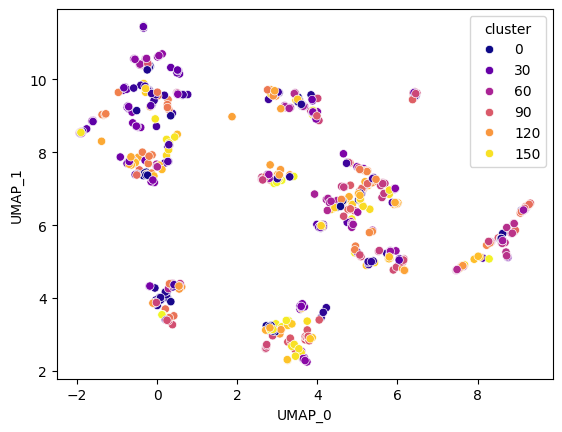

In [19]:
sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='cluster', palette='plasma')

<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

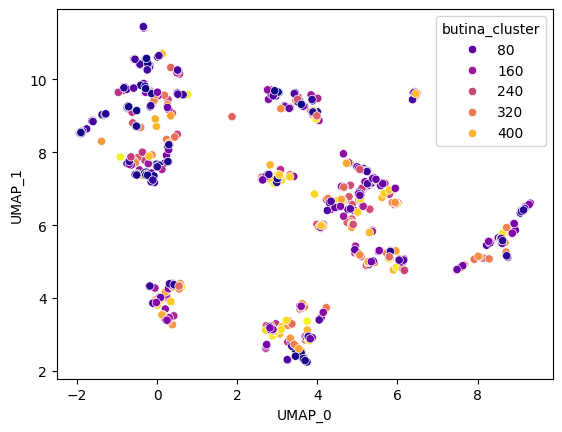

In [20]:
sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='butina_cluster', palette='plasma')

In [21]:
butina_labels = df['butina_cluster'].to_list()
medoid_labels = df['cluster'].to_list()
butina_scores = (silhouette_score(X, butina_labels),davies_bouldin_score(X, butina_labels))
medoid_scores = (silhouette_score(X, medoid_labels),davies_bouldin_score(X, medoid_labels))
print(f"butina_scores:{butina_scores}")
print(f"medoid_scores:{medoid_scores}")

butina_scores:(np.float64(0.2694811766157876), np.float64(0.5631634262418669))
medoid_scores:(np.float64(0.22265667148616794), np.float64(1.5081224841741134))


In [22]:
top_butina_medoids = [i[0] for i in butina_cl[0:50]]

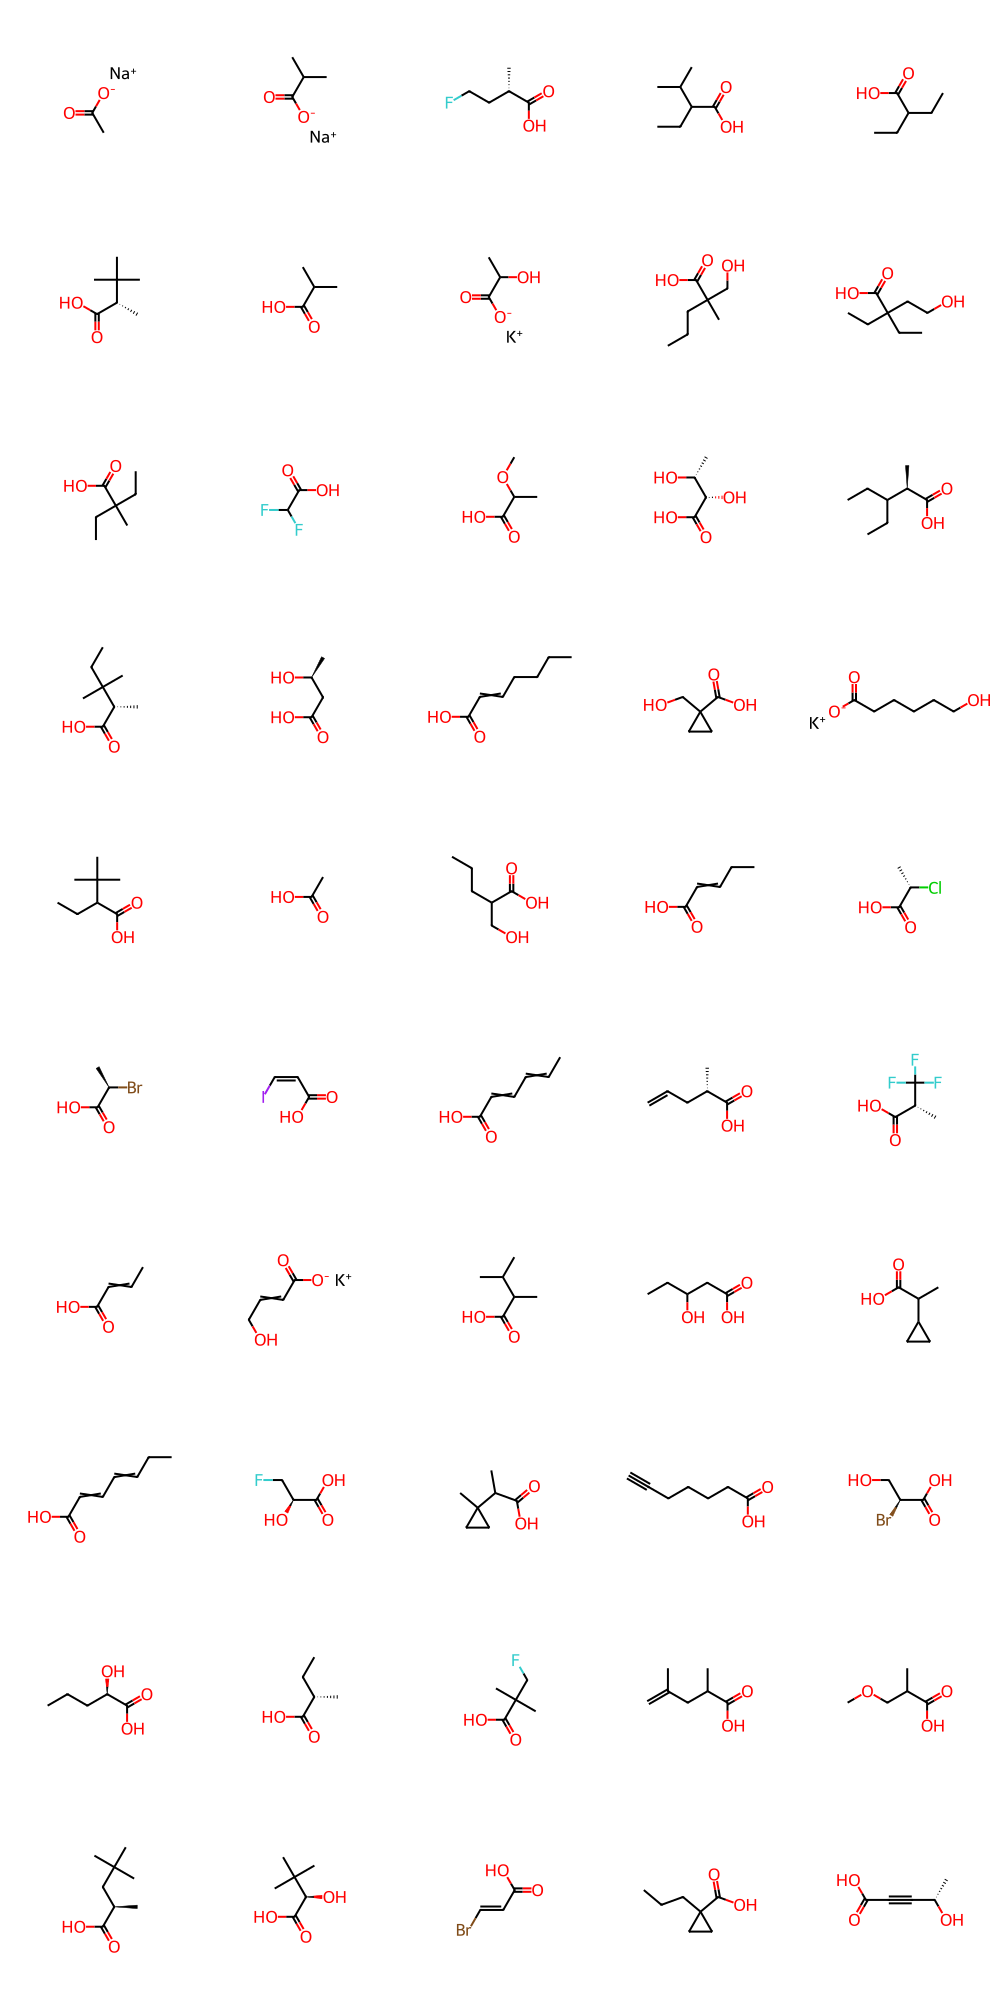

In [23]:
Chem.Draw.MolsToGridImage(df.loc[top_butina_medoids].ROMol.to_list(),molsPerRow=5)
# while Butina scores higher - some of these clusters have some significant overlap.

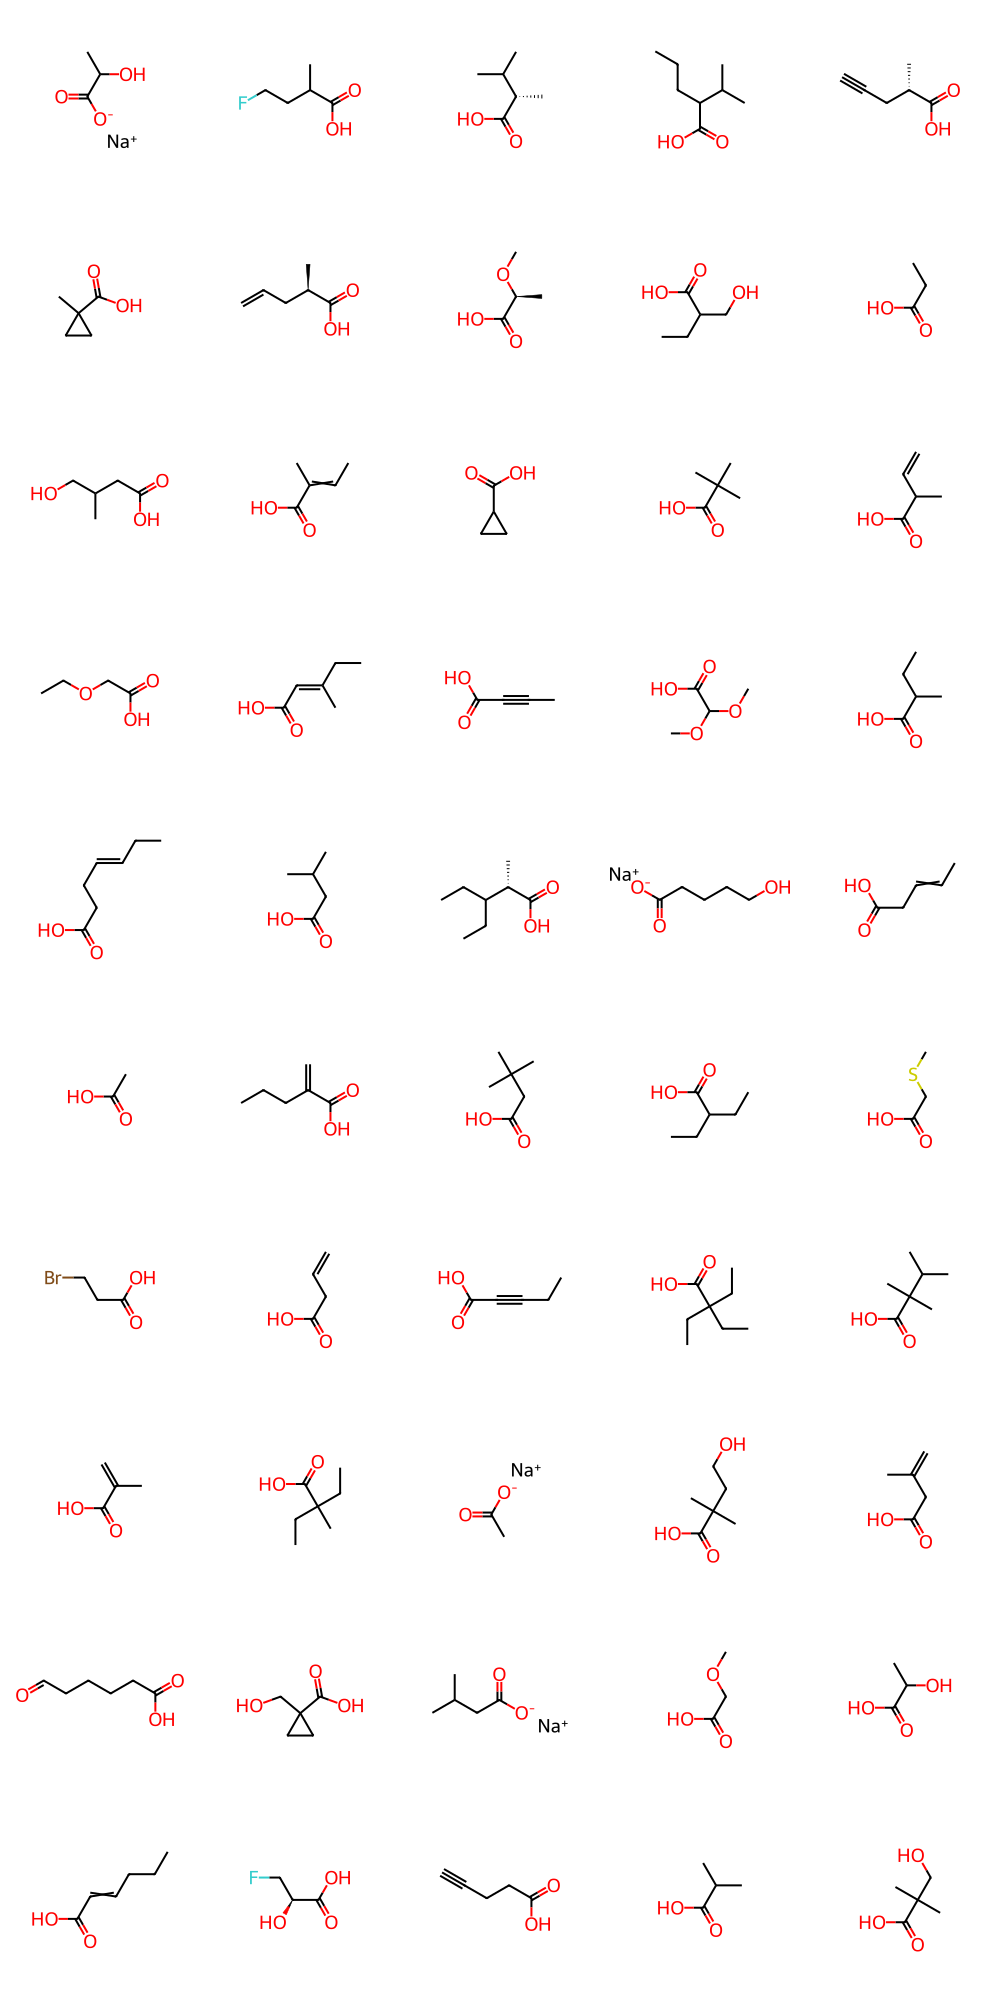

In [29]:
top_mediods = df[(df['cluster'].isin(top_medoid_clusters))&(df['mediod']==True)]
Chem.Draw.MolsToGridImage(top_mediods['ROMol'].to_list(),molsPerRow=5)